In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [28]:
import pathlib
data_dir = pathlib.Path("../dataset_images")

In [29]:
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.bmp')))
print(image_count)

3684


In [30]:
batch_size = 32
scale_down = 1
img_width = int(160 / scale_down)
img_height = int(120 / scale_down)

colour_mode = "rgb"

validation_split = 0.2

seed = 123

class_names = [ "value_0", "value_1", "value_2", "value_3", "value_4", "value_5", "value_6", "value_7", "value_8", "value_9", "value_10", "value_11", "value_12", "value_13", "value_14", "value_15", "value_16", "value_17", "value_18", "value_19", "value_20", "value_21", "value_22", "value_23", "value_24", "value_25", "value_26", "value_27", "value_28", "value_29", "value_30", "value_31", "value_32", "value_33", "value_34", "value_35", "value_36", "value_37", "value_38", "value_39"]

In [31]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="training",
  class_names=class_names,
  color_mode=colour_mode,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3684 files belonging to 40 classes.
Using 2948 files for training.


In [32]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="validation",
  class_names=class_names,
  color_mode=colour_mode,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3684 files belonging to 40 classes.
Using 736 files for validation.


In [33]:
class_names = train_ds.class_names
print(class_names)

['value_0', 'value_1', 'value_2', 'value_3', 'value_4', 'value_5', 'value_6', 'value_7', 'value_8', 'value_9', 'value_10', 'value_11', 'value_12', 'value_13', 'value_14', 'value_15', 'value_16', 'value_17', 'value_18', 'value_19', 'value_20', 'value_21', 'value_22', 'value_23', 'value_24', 'value_25', 'value_26', 'value_27', 'value_28', 'value_29', 'value_30', 'value_31', 'value_32', 'value_33', 'value_34', 'value_35', 'value_36', 'value_37', 'value_38', 'value_39']


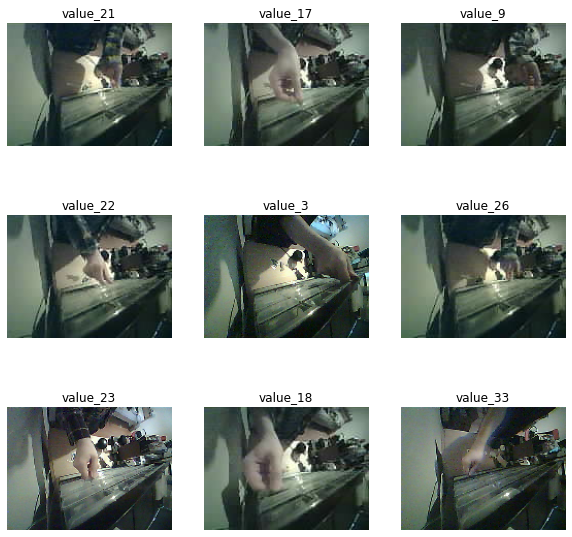

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [35]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
num_classes = len(class_names)

factor = 0.25

model = Sequential([
  # layers.GaussianNoise(stddev=0.02, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(factor * 8, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
  layers.MaxPooling2D(),
  # layers.Conv2D(factor * 6, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  layers.Conv2D(factor * 4, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # layers.Conv2D(factor * 2, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(2 * num_classes, activation='relu'),
  layers.Dense(num_classes)
])

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 120, 160, 2)       56        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 80, 2)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 80, 1)         19        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 40, 1)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 40, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 80)               

In [39]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [40]:
epochs=400
history = model.fit(
  normalized_train_ds,
  validation_data=normalized_val_ds,
  epochs=epochs
)

cy: 0.9987 - val_loss: 0.4035 - val_accuracy: 0.9416
Epoch 264/400
93/93 [==============================] - 11s 114ms/step - loss: 0.0039 - accuracy: 0.9990 - val_loss: 0.4275 - val_accuracy: 0.9307
Epoch 265/400
93/93 [==============================] - 11s 117ms/step - loss: 0.0039 - accuracy: 0.9995 - val_loss: 0.4425 - val_accuracy: 0.9307
Epoch 266/400
93/93 [==============================] - 11s 118ms/step - loss: 0.0263 - accuracy: 0.9933 - val_loss: 0.5439 - val_accuracy: 0.9198
Epoch 267/400
93/93 [==============================] - 11s 118ms/step - loss: 0.0183 - accuracy: 0.9932 - val_loss: 0.5178 - val_accuracy: 0.9198
Epoch 268/400
93/93 [==============================] - 10s 112ms/step - loss: 0.0140 - accuracy: 0.9936 - val_loss: 0.4959 - val_accuracy: 0.9253
Epoch 269/400
93/93 [==============================] - 11s 113ms/step - loss: 0.0051 - accuracy: 0.9980 - val_loss: 0.5016 - val_accuracy: 0.9171
Epoch 270/400
93/93 [==============================] - 11s 113ms/step -

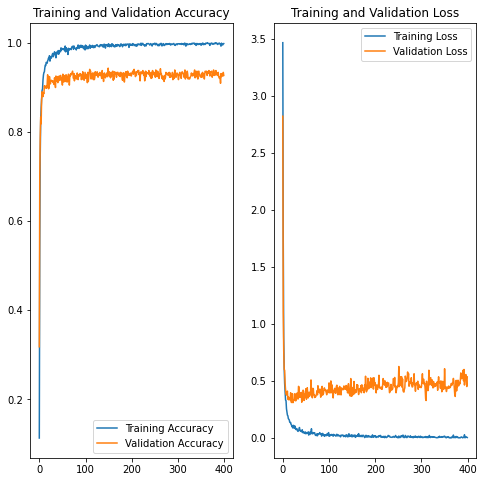

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
def representative_dataset():
  for image_batch, labels_batch in normalized_train_ds:
    yield [image_batch]


In [43]:
model_with_softmax = tf.keras.Sequential([model, layers.Softmax()])

converter = tf.lite.TFLiteConverter.from_keras_model(model_with_softmax)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]



tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/1q/_vlxftdn3gn_h6kg3ty1b2jr0000gn/T/tmpym4lhud4/assets
INFO:tensorflow:Assets written to: /var/folders/1q/_vlxftdn3gn_h6kg3ty1b2jr0000gn/T/tmpym4lhud4/assets


In [44]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_quant_model)

In [45]:
  
import re
import hexdump
def outputTFLModel(tflite_model, variable_name='model_data', pretty_print=False):
    bytes = hexdump.dump(tflite_model).split(' ')
    c_array = ', '.join(['0x%02x' % int(byte, 16) for byte in bytes])
    c = 'const unsigned char %s[] DATA_ALIGN_ATTRIBUTE = {%s};' % (variable_name, c_array)
    if pretty_print:
        c = c.replace('{', '{\n\t').replace('}', '\n}')
        c = re.sub(r'(0x..?, ){12}', lambda x: '%s\n\t' % x.group(0), c)
    c += '\nconst int %s_len = %d;' % (variable_name, len(bytes))
    preamble = '''
// if having troubles with min/max, uncomment the following
// #undef min    
// #undef max
#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif
'''
    return preamble + c

In [46]:

# from tinymlgen import port
# c_code = port(model, pretty_print=False, optimize=True)
c_code = outputTFLModel(tflite_quant_model)
print(c_code)

, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0xff, 0xff, 0xff, 0xff, 0x28, 0x00, 0x00, 0x00, 0xfc, 0xf4, 0xff, 0xff, 0x14, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x80, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x80, 0x3b, 0x0d, 0x00, 0x00, 0x00, 0x49, 0x64, 0x65, 0x6e, 0x74, 0x69, 0x74, 0x79, 0x5f, 0x69, 0x6e, 0x74, 0x38, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x28, 0x00, 0x00, 0x00, 0xb0, 0xf4, 0xff, 0xff, 0x00, 0x00, 0x00, 0x09, 0xb4, 0x00, 0x00, 0x00, 0x11, 0x00, 0x00, 0x00, 0x54, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0xff, 0xff, 0xff, 0xff, 0x28, 0x00, 0x00, 0x00, 0x94, 0xf4, 0xff, 0xff, 0x30, 0x00, 0x00, 0x00, 0x24, 0x00, 0x00, 0x00, 0x18, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x11, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x

In [47]:
src_dir = pathlib.Path("../src")
model_file = open(src_dir / "model.h", "w")
model_file.write(c_code)
model_file.close()

In [48]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

[{'name': 'sequential_2_input', 'index': 18, 'shape': array([  1, 120, 160,   3], dtype=int32), 'shape_signature': array([ -1, 120, 160,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 19, 'shape': array([ 1, 40], dtype=int32), 'shape_signature': array([-1, 40], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [49]:
input_shape = input_details[0]['shape']
print(input_details)

[{'name': 'sequential_2_input', 'index': 18, 'shape': array([  1, 120, 160,   3], dtype=int32), 'shape_signature': array([ -1, 120, 160,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


<TakeDataset shapes: ((None, 120, 160, 3), (None,)), types: (tf.float32, tf.int32)>


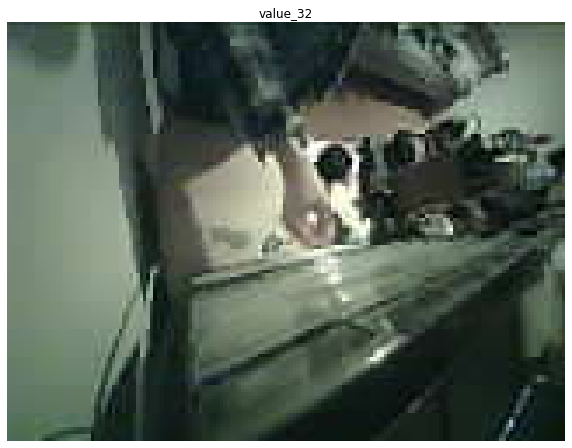

In [135]:
real_input = 0
print(normalized_val_ds.take(1))
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  plt.imshow(images[0].numpy().astype("uint8"))
  real_input = images[0].numpy().astype("float32") / 255
  plt.title(class_names[labels[0]])
  plt.axis("off")
interpreter.set_tensor(input_details[0]['index'], [real_input])

In [136]:
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.99609375 0.         0.         0.
  0.         0.         0.         0.        ]]


In [137]:
np.where(output_data[0] == np.max(output_data[0]))


(array([32]),)